14.331594840262477


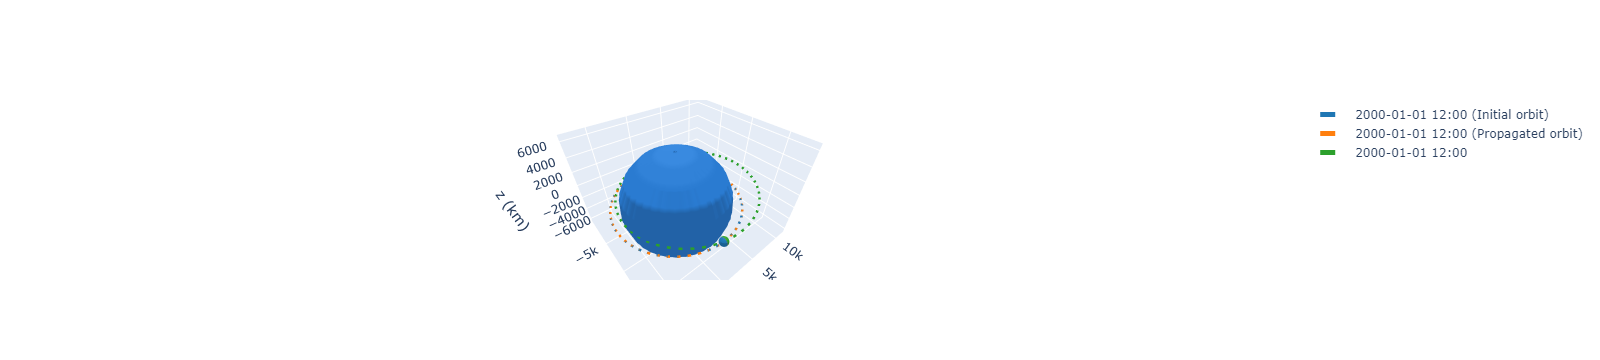

In [68]:
import numpy as np
import math
import navpy
import datetime

from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import (
    CartesianRepresentation,
    AltAz,
    EarthLocation,
    GCRS,
    ITRS,
)
from astropy import coordinates as coord

from poliastro.bodies import Earth
from poliastro.earth import EarthSatellite
from poliastro.maneuver import Maneuver
from poliastro.earth.enums import EarthGravity
from poliastro.spacecraft import Spacecraft
from poliastro.twobody.orbit import Orbit
from poliastro.frames import Planes
from poliastro.plotting import OrbitPlotter3D
from poliastro.examples import iss
from poliastro.core.spheroid_location import cartesian_to_ellipsoidal
from poliastro.core.spheroid_location import tangential_vecs

# Comments from the author:
# This project is one of the worst I've ever embarked on. It was incredibly rough to code, formulate, and overall just an absolute nightmare.

# ------- HELPER METHODS --------


# Units: m, m/s, kg
# Evil math
def compute_time_int(al, vi, mas):
    """Evil math to compute the delta t of a maneuver

    Args:
        al (_type_): _description_
        vi (_type_): _description_
        mas (_type_): _description_

    Returns:
        _type_: _description_
    """
    return 8.50938 * (10**-9) * (
        14609987571408820 * (al**2) * mas
        + math.sqrt(
            213451736836720196366365882318848 * (al**4) * (mas**2)
            + 7452623680028430827520 * (al**3) * (mas**3) * (vi**3)
        )
    ) ** (1 / 3) - (0.166214 * al * mas * vi) / (
        14609987571408820 * (al**2) * mas
        + math.sqrt(
            213451736836720196366365882318848 * (al**4) * (mas**2)
            + 7452623680028430827520 * (al**3) * (mas**3) * (vi**3)
        )
    ) ** (
        1 / 3
    )


# Units: s, kg, m/s
def compute_vf(dt, mas, vi):
    return math.sqrt(((4 * (10**8)) * dt) / mas + vi**2)

def compute_dv(vi, al, mas):
    dt = compute_time_int(al, vi, mas)
    vf = compute_vf(dt, mas, vi)
    return vf - vi

def eci2lla(x, y, z, t, unit):
    """Convert Earth-Centered Inertial (ECI) cartesian coordinates to latitude, longitude, and altitude, using astropy.

    Inputs :
    x = ECI X-coordinate
    y = ECI Y-coordinate 
    z = ECI Z-coordinate
    t = UTC time (datetime object)
    unit = units the coordinates are in

    Outputs :
    lon = longitude (degrees)
    lat = geodetic latitude (degrees)
    alt = height above WGS84 ellipsoid (m)
    """
    # position of satellite in GCRS or J20000 ECI:
    cartrep = coord.CartesianRepresentation(x, y, z, unit=u.m)
    gcrs = coord.GCRS(cartrep, obstime=t)
    itrs = coord.GCRS(cartrep, obstime=t).transform_to(coord.ITRS(obstime=t))
    loc = coord.EarthLocation(*itrs.cartesian.xyz)
    return loc.lat.value, loc.lon.value, (loc.height.to(u.m)).value

def compute_time_off(dt: float) -> datetime:
    """Returns a datetime object with an offset from J2000 Epoch (Default)

    Args:
        dt - float: The time passed since initial orbit creation (Assumed in J2000 frame)

    Returns:
        datetime: a new datetime object 
    """
    return datetime.datetime(2000, 1, 1, 12, 0) + datetime.timedelta(seconds=dt)

def get_altitude(orb: Orbit, time: datetime):
    orb_x = orb.r.value[0]
    orb_y = orb.r.value[1]
    orb_z = orb.r.value[2]
    un = u.m
    _, _, ret_alt = eci2lla(orb_x, orb_y, orb_z, time, un)
    return ret_alt

def compute_eci_vec(dv, orb: Orbit, epoch):
    cart_coords = orb.r.value
    
    lo, la, al = eci2lla2(cart_coords[0], cart_coords[1], cart_coords[2], epoch, u.m)
    ned = [0, dv/10, 0]
    lat_ref = la
    lon_ref = lo
    alt_ref = al
    ecefRep = ((navpy.ned2ecef(ned, lat_ref, lon_ref, alt_ref)) << u.m / u.s).to(
        u.km / u.s
    )

    gcrs = coord.ITRS(
        x=orb.r[0],
        y=orb.r[1],
        z=orb.r[2],
        v_x=ecefRep[0],
        v_y=ecefRep[1],
        v_z=ecefRep[2],
        representation_type="cartesian",
        differential_type="cartesian",
        obstime=epoch,
    )
    itrs = gcrs.transform_to(coord.GCRS(obstime=epoch))
    return itrs.cartesian.differentials['s'].d_xyz

def apply_maneuver_evil(orbit: Orbit, di: float, dv: float, epoch) -> None:
    disc_vel = dv / di
    temp_orbit = orbit
    prev_orbit = None

    for i in range(0, math.floor(di)):
        prev_orbit = temp_orbit
        temp_orbit.apply_maneuver(
            (i * u.s, compute_eci_vec(disc_vel, orbit, epoch + i))
        )

# ------- DEFINE PARAMETERS --------

# Attracting body
attr = Earth
# Coefficient of drag unapplicable, made constant
sat_C_D = 1
# Mass
sat_mass = 1000 * u.kg
# Area
sat_area = (3.4 * (u.m**2)).to(u.km**2)
# Epoch
sat_t = Time.now
# Plane
sat_plane = Planes.EARTH_EQUATOR

# Use if defining orbit from vectors

# # Radius
sat_radius = [-4000, -4000, 3000] << u.km
# # Velocity
sat_velocity = [-3.457, 6.618, 2.533] << u.km / u.s

# Use if defining orbit from classical parameters

attr = Earth
a = 40000 << u.km
ecc = 0.093315 << u.one
inc = 1.85 << u.deg
raan = 49.562 << u.deg
argp = 286.537 << u.deg
nu = 23.33 << u.deg

# ------- DEFINE AN ORBIT & FRAME --------

# Use if defining an orbit from vectors
# sat_orbit = Orbit.from_vectors(sat_radius, sat_velocity)

# Use if defining an orbit from classical parameters
# sat_orbit = Orbit.from_classical(attr, a, ecc, inc, raan, argp, nu)

# Preferred case/default: Use orbit.circular
sat_orbit = Orbit.circular(Earth, alt=1000 << u.km)

# ------- ORBIT PLOTTER SETUP --------

plotter = OrbitPlotter3D()

# ------- MANEUVERS --------

# Impulse template

# (time * u.unit, [x comp, y comp, z comp] * u.unit) -> Impulses applied as dv at instant t(i)

# Maneuver template

vi1 = 7000
sat_alt1 = get_altitude(sat_orbit, compute_time_off(0))
m1 = sat_mass.value

dt1 = compute_time_int(sat_alt1, vi1, m1)
# print(vf1)
dv1 = compute_dv(vi1, sat_alt1, m1)
print(dv1/dt1)

plotter.plot(sat_orbit, label="Initial orbit")
man_vec = compute_eci_vec(dv1 / dt1, sat_orbit_test, compute_time_off(0))
sat_orbit_test = sat_orbit.propagate(1 * u.s)

# sat_orbit2 = sat_orbit.apply_maneuver(man)
plotter.plot(sat_orbit_test, label="Propagated orbit")
sat_orbit_man1 = sat_orbit_test.apply_maneuver(Maneuver((1 * u.s, compute_eci_vec(dv1, sat_orbit_test, compute_time_off(1)) << u.km / u.s)))

plotter.plot(sat_orbit_man1)


